In [1]:
import librosa
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from librosa import display
from sklearn.cluster import KMeans
import keras, tensorflow
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, Conv1D, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling1D, LSTM
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
instrument_="kick"
path='/content/drive/MyDrive/malis project/FINAL/data/'+instrument_+'/'
testfalse='data'+instrument_+'_testfalse1.csv'
testtrue='data'+instrument_+'_testtrue1.csv'
trainfalse='data'+instrument_+'_trainfalse1.csv'
traintrue='data'+instrument_+'_traintrue1.csv'

In [4]:
n_fft=40
hop_length=20
n_mels=128

In [5]:
data_testfalse=[]
df=pd.read_csv(path+testfalse).iloc[:,1:]
for i in df.columns:
  data_testfalse.append(df[str(i)].values)

data_testtrue=[]
df=pd.read_csv(path+testtrue).iloc[:,1:]
for i in df.columns:
  data_testtrue.append(df[str(i)].values)

data_trainfalse=[]
df=pd.read_csv(path+trainfalse).iloc[:,1:]
for i in df.columns:
  data_trainfalse.append(df[str(i)].values)

data_traintrue=[]
df=pd.read_csv(path+traintrue).iloc[:,1:]
for i in df.columns:
  data_traintrue.append(df[str(i)].values)

In [6]:
data_trainfalse[5].shape

(6615,)

In [7]:
def gety(x,bool_):
  if bool_==True:
    y=np.ones((len(x),1))
  if bool_==False:
    y=np.zeros((len(x),1))
  return y

In [8]:
def to_mel(x, n_fft, hop_length, n_mels):
  return librosa.feature.melspectrogram(x, sr=22050, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

In [9]:
def global_normalisation_fit(x):
  sample_means=[]
  sample_stds=[]
  for i in range(len(x)):
    sample_means.append(x[i].mean())
    sample_stds.append(x[i].std())
  mean=np.array(sample_means).mean()
  std=np.array(sample_stds).mean()
  return mean, std

def global_normalisation_transf(x, x_test):
  mean, std=global_normalisation_fit(x)
  for i in range(len(x)):
    x[i]=x[i]-mean
    x[i]=x[i]/std
  for i in range(len(x_test)):
    x_test[i]=x_test[i]-mean
    x_test[i]=x_test[i]/std
  return x, x_test, mean, std


In [10]:
ytestfalse=gety(data_testfalse, True)
ytesttrue=gety(data_testtrue, False)
ytrainfalse=gety(data_trainfalse, True)
ytraintrue=gety(data_traintrue, False)

In [11]:
X=np.vstack((data_traintrue,data_trainfalse))
y=np.vstack((ytraintrue,ytrainfalse))
X_train, ytrain = shuffle(X, y)

X=np.vstack((data_testtrue,data_testfalse))
y=np.vstack((ytesttrue,ytestfalse))
X_test, ytest = shuffle(X, y)

y_train = to_categorical(ytrain, num_classes = 2) 
y_test = to_categorical(ytest, num_classes = 2)

In [12]:
Xtrain=np.zeros((len(X_train),to_mel(X_train[0], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels).shape[1],to_mel(X_train[0], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels).shape[0]))
Xtest=np.zeros((len(X_test),to_mel(X_test[0], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels).shape[1],to_mel(X_test[0], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels).shape[0]))

for i in range(len(X_train)):
  Xtrain[i]=np.transpose(np.flip(to_mel(X_train[i], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),axis=1))

for i in range(len(X_test)):
  Xtest[i]=np.transpose(np.flip(to_mel(X_test[i], n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),axis=1))


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [13]:
Xtrain, Xtest, mean, std=global_normalisation_transf(Xtrain, Xtest)
print(mean, std)

0.001662474070358443 0.03143155640633864


In [14]:
Xtrain.shape

(5310, 331, 128)

In [18]:
def lstm(shape_):
  inp = Input(shape=(shape_[1], shape_[2]))
  #x=LSTM(128, return_sequences=True)(inp) #, dropout=0.1, return_sequences=True)(inp)
  x = Conv1D(filters=10, kernel_size=3, activation='relu')(inp)
  x = MaxPooling1D(pool_size=2)(x)
  x = Dropout(0.1)(x)
  #x = Conv1D(filters=7, kernel_size=5, activation='relu')(x)
  #x = MaxPooling1D(pool_size=2)(x)
  x=LSTM(25, dropout=0.15)(x)
  x = Dropout(0.1)(x)
  #x = Dense(32, activation='relu')(x)
  x = Dense(12, activation='relu')(x)
  x = Dropout(0.05)(x)
  x = Dense(6, activation='relu')(x)
  output = Dense(2, activation='softmax')(x)
  model = Model(inputs=inp, outputs=output)
  model.summary()
  return model

In [19]:
model=lstm(Xtrain.shape)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
history=model.fit(Xtrain, y_train, batch_size=32, epochs=100, validation_data=[Xtest,y_test], verbose=1, shuffle=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 331, 128)]        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 329, 10)           3850      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 164, 10)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 164, 10)           0         
                                                                 
 lstm_1 (LSTM)               (None, 25)                3600      
                                                                 
 dropout_3 (Dropout)         (None, 25)                0         
                                                           

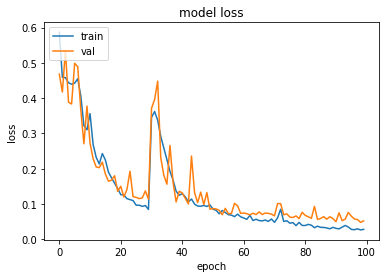

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

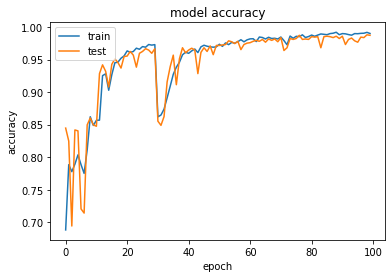

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
test=[]
for i in range(len(ytest)):
  test.append(ytest[i][0])
test=np.array(test)

In [23]:
from sklearn.metrics import classification_report
preds=model.predict(Xtest)
y_classes = preds.argmax(axis=-1)
print(classification_report(test, y_classes)) # note true when zero

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       705
         1.0       0.98      1.00      0.99       705

    accuracy                           0.99      1410
   macro avg       0.99      0.99      0.99      1410
weighted avg       0.99      0.99      0.99      1410



In [24]:
model.save(path+'model_kick')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/malis project/FINAL/data/kick/model_kick/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/malis project/FINAL/data/kick/model_kick/assets


In [25]:
model = keras.models.load_model(path+'model_kick')

In [26]:
from sklearn.metrics import classification_report
preds=model.predict(Xtest)
y_classes = preds.argmax(axis=-1)
print(classification_report(test, y_classes))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       705
         1.0       0.98      1.00      0.99       705

    accuracy                           0.99      1410
   macro avg       0.99      0.99      0.99      1410
weighted avg       0.99      0.99      0.99      1410

